In [123]:
import cv2
import numpy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [124]:
path = Path("cathedral")
result_path = path/"result.png"
img_paths = [p for p in path.iterdir() if str(p) !=str(result_path)]
img_paths = sorted(img_paths)
result = cv2.imread(str(result_path), cv2.IMREAD_COLOR)
imgs = np.array([cv2.imread(str(p), cv2.IMREAD_COLOR) for p in img_paths])
imgs.shape

(5, 500, 752, 3)

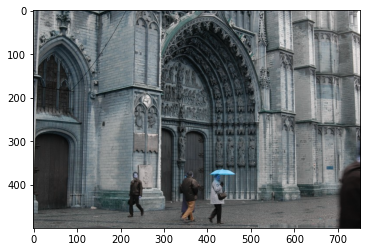

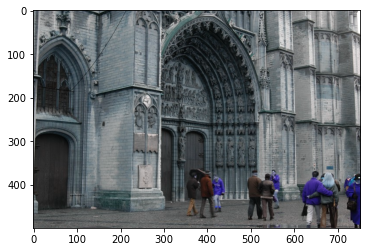

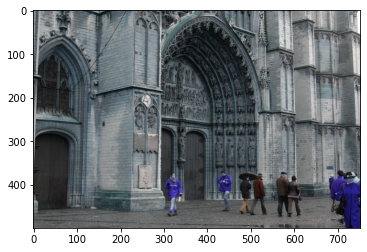

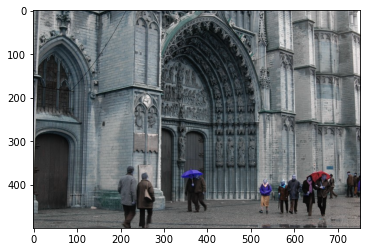

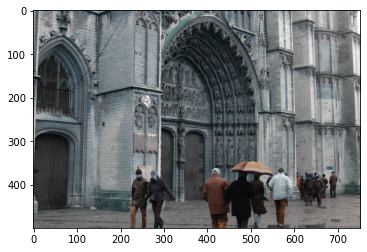

In [125]:
for img in imgs:
    plt.imshow(img)
    plt.show()

## Mean filter

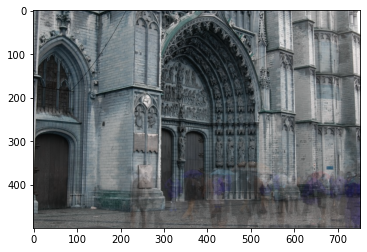

In [126]:
plt.imshow(np.mean(imgs, axis=0).astype(np.uint16))
plt.show()

## Median filter

(500, 752, 3)


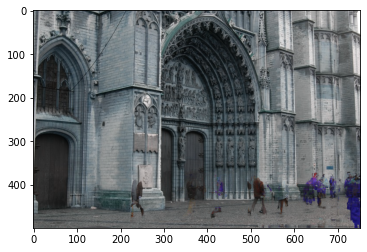

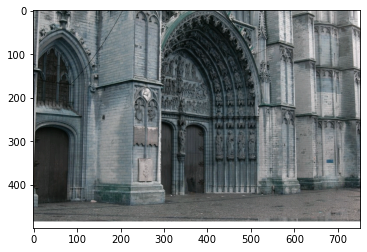

In [127]:
our_result = np.median(imgs, axis=0).astype(np.uint16)
print(our_result.shape)
plt.imshow(our_result)
plt.show()
plt.imshow(result)

Closest to mean

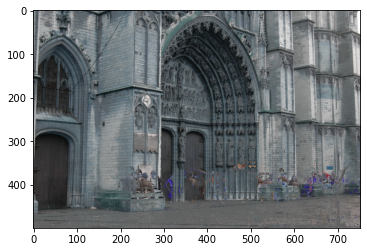

In [128]:
mean = np.mean(imgs,axis=(0,1,2))
distances = np.sum((imgs - mean)**2, axis=3)
indices = np.argmin(distances, axis = 0)
indices = np.stack((indices,)*3, axis=-1)
our_result = np.take_along_axis(imgs, indices[np.newaxis], axis=0)[0]
plt.imshow(our_result)
plt.show()

/home/kacper/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


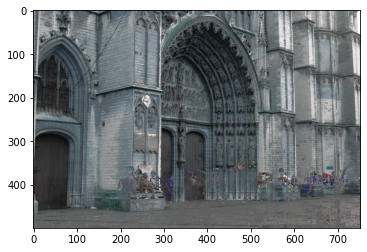

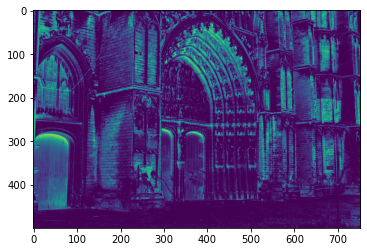

In [129]:
mean = np.mean(imgs,axis=(0,1,2))
m = 2
distance_candidates = (np.sum((imgs - color)**m, axis=3) for color in [mean, np.array([255,255,255]), np.array([81,96,93])])
distances = np.min(np.stack(distance_candidates, axis = -1), axis=-1)
indices = np.argmin(distances, axis = 0)
indices = np.stack((indices,)*3, axis=-1)
our_result = np.take_along_axis(imgs, indices[np.newaxis], axis=0)[0]
plt.imshow(our_result)
plt.show()
plt.imshow(np.min(distances, axis=0))
plt.show()

## Edge detection

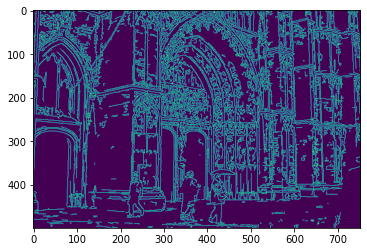

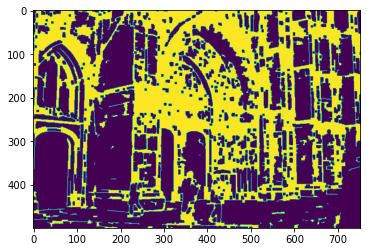

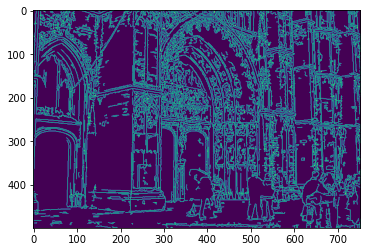

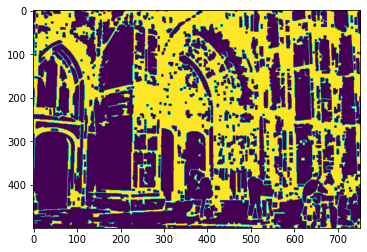

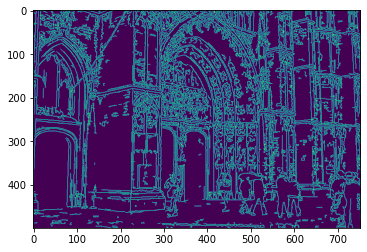

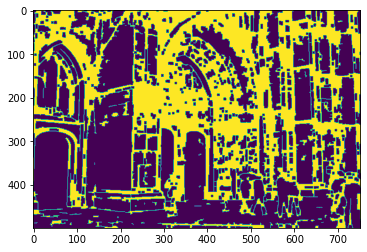

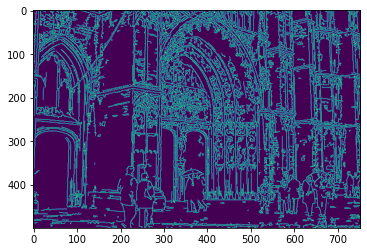

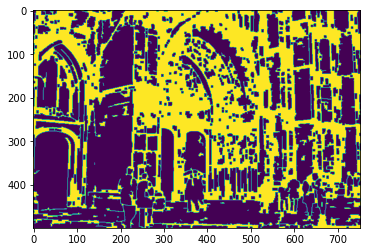

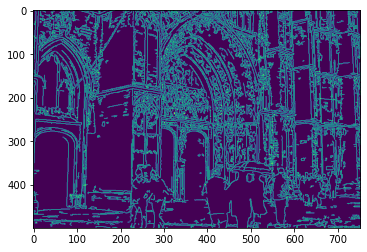

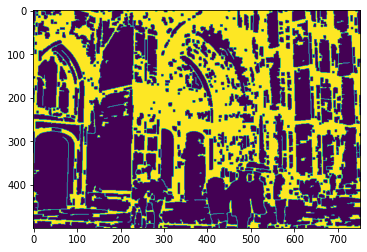

In [130]:
for img in imgs:
    edges = cv2.Canny(img,100,200)
    plt.imshow(edges)
    plt.show()
    struct = np.ones([5, 5], np.uint8)
    cls = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, struct)
#     cls = cv2.morphologyEx(cls, cv2.MORPH_OPEN, struct)
    plt.imshow(cls)
    plt.show()
    

[255]


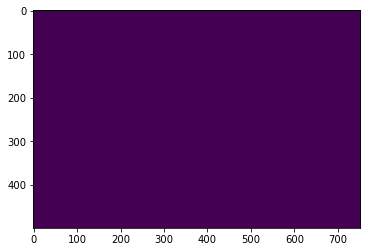

[255]


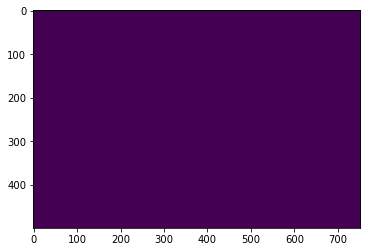

[  0 255]


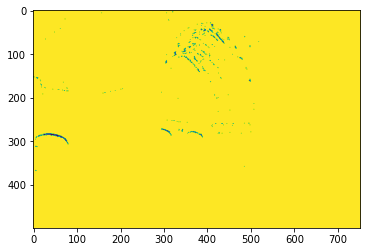

[  0 255]


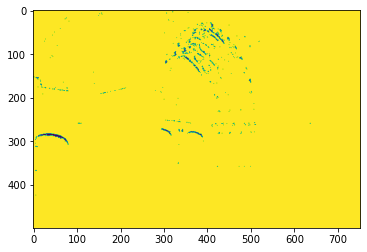

[  0 127 255]


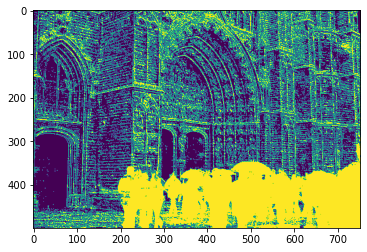

In [131]:
backSub = cv2.createBackgroundSubtractorKNN()
for img in imgs:
    fgMask = backSub.apply(img)
    print(np.unique(fgMask))
    plt.imshow(fgMask)
    plt.show()

## Removing people

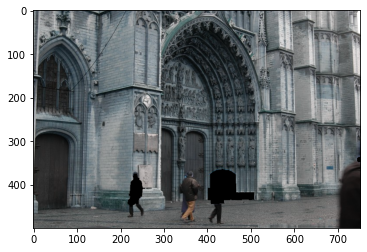

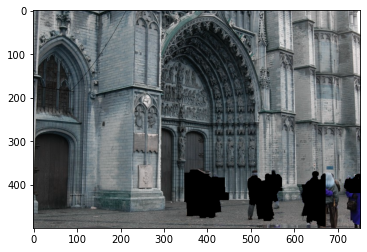

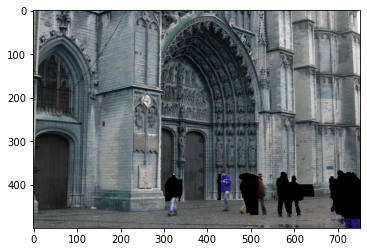

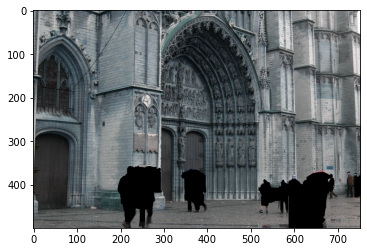

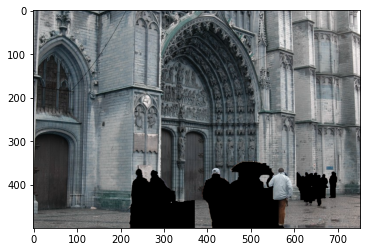

In [157]:
def delete_people(img,img_bbox, border=40):
    def get_points(img,filter2d):
        cadidates = (cv2.filter2D(img, -1,filter2d) == 3).astype(np.uint8)
        corners = np.where(cadidates == 1)
        return [(x,y) for x,y in zip(corners[0], corners[1])]

    res = np.all((img_bbox == np.array([0,255,0])),axis=2).astype(np.uint8)
    left_up = np.array([
        [1,1],
        [1,-1]
    ])

    top_left_corners = get_points(res, left_up)

    right_bottom = np.array([
        [-1,1],
        [1,1]
    ])

    bottom_right_corners = get_points(res, right_bottom)
    from scipy.spatial.distance import cdist
    from scipy.optimize import linear_sum_assignment

    distances = cdist(top_left_corners,bottom_right_corners)

    _, assigment = linear_sum_assignment(distances)
    boxes = [(top_left_corners[i][0],
              top_left_corners[i][1],
             bottom_right_corners[assigment[i]][0],
             bottom_right_corners[assigment[i]][1]) for i in range(len(assigment))]

    final_mask = np.zeros(img.shape[:2], dtype=np.uint8)

    for box in boxes:
        new_x1 = max(box[0]-border,0)
        new_y1 = max(box[1]-border,0)
        new_x2 = min(box[2]+border, img.shape[0])
        new_y2 = min(box[3]+border, img.shape[1])

        cur_img = img[new_x1:new_x2,new_y1:new_y2]
        rect = (box[0]-new_x1,box[1]-new_y1,box[2]-new_x1,box[3]-new_y1)
        mask = np.zeros(res.shape[:2], dtype="uint8")
        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")
        (mask, bgModel, fgModel) = cv2.grabCut(cur_img, mask, rect, bgModel,
            fgModel, 3, mode=cv2.GC_INIT_WITH_RECT)

        outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),
            0,1)
        outputMask = (outputMask * 255).astype("uint8")
        final_mask[new_x1:new_x2,new_y1:new_y2] = outputMask

    output = cv2.bitwise_and(img, img, mask=255 -final_mask)
    return output, final_mask
    
    
for i in range(1,6):
    test = cv2.imread(f"boxes/d00{i}-boxes.png", cv2.IMREAD_COLOR)
    img = cv2.imread(f"cathedral/d00{i}.jpg", cv2.IMREAD_COLOR)
    output, final_mask = delete_people(img,test, 40)
    plt.imshow(output)
    plt.show()
#     plt.imshow(output + np.stack((final_mask == 255,)*3, axis=-1)*np.full(output.shape, 167))
#     plt.show()

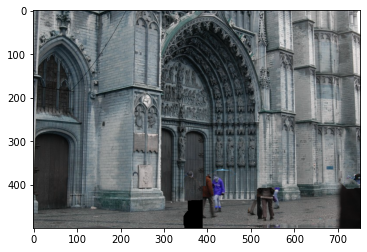

In [156]:
final = np.full(imgs[0].shape,0)

for i in range(1,6):
    test = cv2.imread(f"boxes/d00{i}-boxes.png", cv2.IMREAD_COLOR)
    img = cv2.imread(f"cathedral/d00{i}.jpg", cv2.IMREAD_COLOR)
    output, final_mask = delete_people(img,test, 100)
    cur_mask = np.stack((np.all(final == np.array([0,0,0]), axis=-1),)*3, axis=-1)
    final += output*cur_mask

plt.imshow(final)
plt.show()
#     plt.imshow(output + np.stack((final_mask == 255,)*3, axis=-1)*np.full(output.shape, 167))
#     plt.show()

In [163]:
def delete_boxes(img,img_bbox):
    def get_points(img,filter2d):
        cadidates = (cv2.filter2D(img, -1,filter2d) == 3).astype(np.uint8)
        corners = np.where(cadidates == 1)
        return [(x,y) for x,y in zip(corners[0], corners[1])]

    res = np.all((img_bbox == np.array([0,255,0])),axis=2).astype(np.uint8)
    left_up = np.array([
        [1,1],
        [1,-1]
    ])

    top_left_corners = get_points(res, left_up)

    right_bottom = np.array([
        [-1,1],
        [1,1]
    ])

    bottom_right_corners = get_points(res, right_bottom)
    from scipy.spatial.distance import cdist
    from scipy.optimize import linear_sum_assignment

    distances = cdist(top_left_corners,bottom_right_corners)

    _, assigment = linear_sum_assignment(distances)
    boxes = [(top_left_corners[i][0],
              top_left_corners[i][1],
             bottom_right_corners[assigment[i]][0],
             bottom_right_corners[assigment[i]][1]) for i in range(len(assigment))]

    final_image = img.copy()
    
    for box in boxes:
        new_x1 = max(box[0],0)
        new_y1 = max(box[1],0)
        new_x2 = min(box[2], img.shape[0])
        new_y2 = min(box[3], img.shape[1])

        final_image[new_x1:new_x2,new_y1:new_y2,:] = 0
        

    return final_image

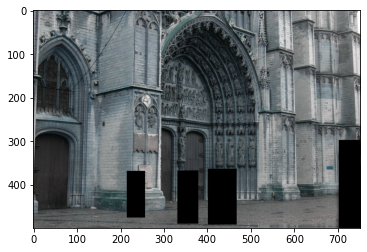

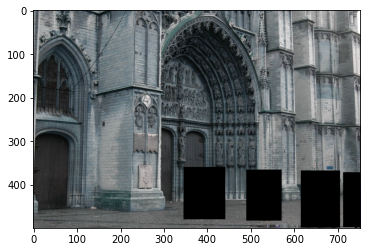

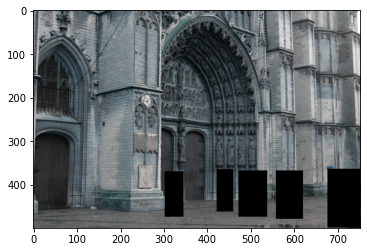

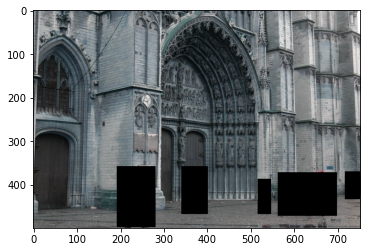

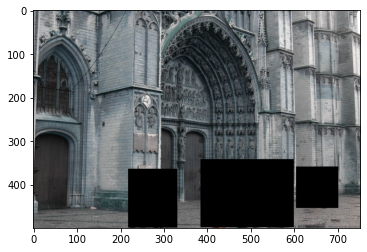

In [164]:
for i in range(1,6):
    test = cv2.imread(f"boxes/d00{i}-boxes.png", cv2.IMREAD_COLOR)
    img = cv2.imread(f"cathedral/d00{i}.jpg", cv2.IMREAD_COLOR)
    output = delete_people(img,test)
    plt.imshow(output)
    plt.show()

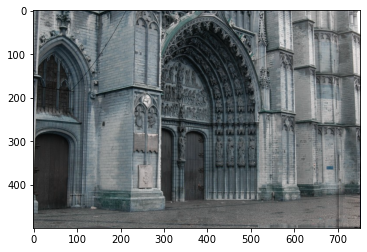

In [166]:
final = np.full(imgs[0].shape,0)

for i in range(1,6):
    test = cv2.imread(f"boxes/d00{i}-boxes.png", cv2.IMREAD_COLOR)
    img = cv2.imread(f"cathedral/d00{i}.jpg", cv2.IMREAD_COLOR)
    output = delete_boxes(img,test)
    cur_mask = np.stack((np.all(final == np.array([0,0,0]), axis=-1),)*3, axis=-1)
    final += output*cur_mask

plt.imshow(final)
plt.show()